## Prepare imports

In [7]:
import torch
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

from models.vae_mnist import VanillaVAE
from models.vae_modelnet import BaseModel as BaseVAE
from models.ectencoder_modelnet import BaseModel as EctEncoder
from datasets.modelnet import ModelNetDataModule, ModelNetDataModuleConfig
from layers.ect import EctLayer, EctConfig

from metrics.metrics import get_mse_metrics
from metrics.accuracies import compute_mse_accuracies
from metrics.loss import compute_mse_loss_fn
from directions import generate_3d_directions


DEVICE = "cuda:0"


config = OmegaConf.load("./configs/config_encoder_modelnet.yaml")

## Load Models and Data

In [8]:


layer = EctLayer(
    EctConfig(
        num_thetas=config.layer.ect_size,
        bump_steps=config.layer.ect_size,
        normalized=True,
        device=DEVICE,
    ),
    v=generate_3d_directions(config.layer.ect_size, DEVICE),
)

dm = ModelNetDataModule(
    ModelNetDataModuleConfig(name="10", samplepoints=config.data.samplepoints)
)

vae_model = VanillaVAE(in_channels=1, latent_dim=64,img_size=config.layer.ect_size)

# Load the VAE model

metrics = get_mse_metrics()

vae_litmodel = BaseVAE.load_from_checkpoint(
    "./trained_models/vae_modelnet.ckpt",
    model=vae_model,
    training_accuracy=metrics[0],
    test_accuracy=metrics[1],
    validation_accuracy=metrics[2],
    accuracies_fn=compute_mse_accuracies,
    loss_fn=compute_mse_loss_fn,
    learning_rate=0.01,
    layer=layer,
).to(DEVICE)


# Load the encoder 

ect_encoder_litmodel = EctEncoder.load_from_checkpoint(
    f"./trained_models/ectencoder_modelnet.ckpt",
    layer=layer,
    ect_size=config.layer.ect_size,
    hidden_size=config.encodermodel.hidden_size,
    num_pts=config.encodermodel.num_pts,
    num_dims=config.encodermodel.num_dims,
    learning_rate=config.encodermodel.learning_rate,
).to(DEVICE)


## Generate an ECT and use VAE as autoencoder to recreate the ECT

In [9]:
data_loader = dm.val_dataloader()
for batch_idx, features in enumerate(data_loader):
    break

features.to(DEVICE)
ect = layer(features,features.batch).unsqueeze(1)


with torch.no_grad():
    decoded, theinput, z_mean, z_log_var = vae_litmodel.forward(ect)

# Undo the VAE transform
decoded = (decoded + 1 ) / 2

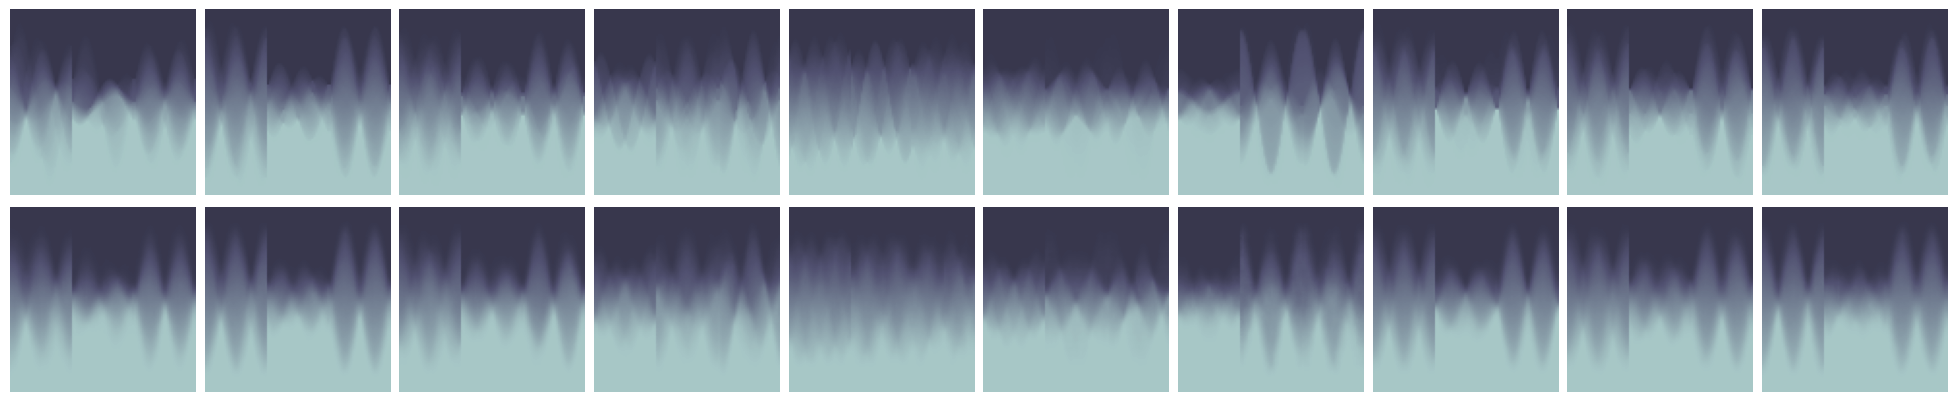

In [10]:
n_images = 10

fig, axes = plt.subplots(
    nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(25,5)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)

for orig_img, recon_img,ax in zip(ect,decoded,axes.T):
    ax[0].imshow(orig_img.cpu().detach().squeeze().numpy(),cmap="bone",vmin=-0.5,vmax=1.5)
    ax[0].axis("off")
    ax[1].imshow(recon_img.cpu().detach().squeeze().numpy(),cmap="bone",vmin=-0.5,vmax=1.5)
    ax[1].axis("off")

plt.savefig("./figures/reconstructed_modelnet/reconstructed_ect.png",transparent=True)

In [11]:
import pyvista as pv

with torch.no_grad():
    recon_batch = ect_encoder_litmodel.model.forward(ect)
    recon_batch_vae = ect_encoder_litmodel.model.forward(decoded)


pl = pv.Plotter(shape=(2, 8), window_size=[1600, 400],border=False,polygon_smoothing=True,off_screen=True)


batch = recon_batch.cpu().detach().numpy()
batch_vae = recon_batch_vae.cpu().detach().numpy()

for idx in range(8):
    points = batch[idx].reshape(-1, 3)
    pl.subplot(0, idx)
    actor = pl.add_points(
        points,
        style="points",
        emissive=False,
        show_scalar_bar=False,
        render_points_as_spheres=True,
        scalars=points[:, 2],
        point_size=10,
        ambient=0.2, 
        diffuse=0.8, 
        specular=0.8,
        specular_power=40, 
        smooth_shading=True
    )
    points_vae = batch_vae[idx].reshape(-1, 3)
    pl.subplot(1, idx)
    actor = pl.add_points(
        points_vae,
        style="points",
        emissive=False,
        show_scalar_bar=False,
        render_points_as_spheres=True,
        scalars=points_vae[:, 2],
        point_size=10,
        ambient=0.2, 
        diffuse=0.8, 
        specular=0.8,
        specular_power=40, 
        smooth_shading=True
    )


pl.background_color = "w"
pl.link_views()
pl.camera_position = "yz"
pos = pl.camera.position
pl.camera.position = (pos[0],pos[1],pos[2]+3)
pl.camera.azimuth = -45
pl.camera.elevation = 10

# create a top down light
light = pv.Light(position=(0, 0, 3), positional=True,
                cone_angle=50, exponent=20, intensity=.2)
pl.add_light(light)
pl.camera.zoom(1.3)
pl.screenshot("./figures/reconstructed_modelnet/reconstructed_pointcloud.png",transparent_background=True,scale=2)
pl.show()
path = pl.generate_orbital_path(n_points=64, shift=2, factor=3.0)
pl.open_gif("./figures/reconstructed_modelnet/orbit_cloud.gif")
pl.orbit_on_path(path, write_frames=True)
pl.close()


Widget(value='<iframe src="http://localhost:51241/index.html?ui=P_0x1f70aff40a0_0&reconnect=auto" class="pyvis…

## Sample from VAE and reconstruct points 

Widget(value='<iframe src="http://localhost:64908/index.html?ui=P_0x14c315e98a0_0&reconnect=auto" class="pyvis…

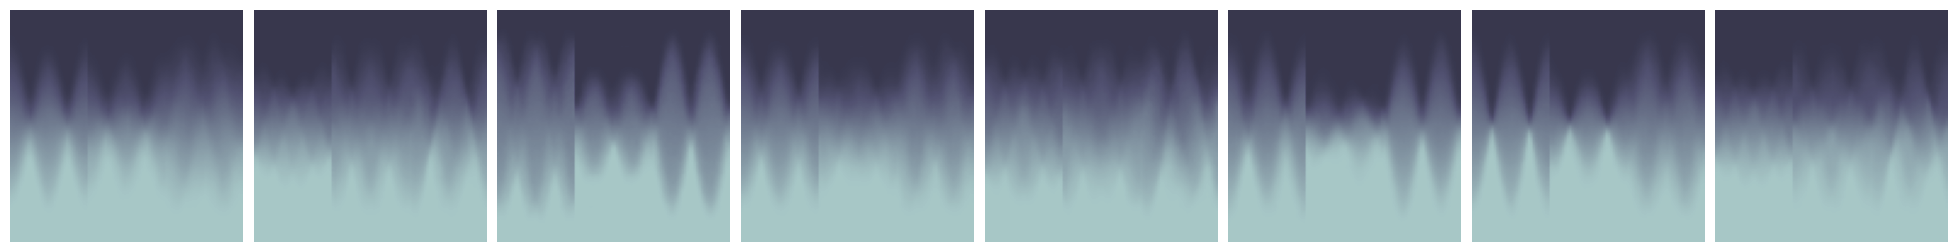

In [ ]:
samples = vae_litmodel.model.sample(64, "cuda:0")
samples = (samples + 1) / 2
n_images = 10


with torch.no_grad():
    recon_batch_samples = ect_encoder_litmodel.model.forward(samples)


n_images = 8
pl = pv.Plotter(shape=(1, 8), window_size=[1600, 200],border=False,polygon_smoothing=True,off_screen=True)

for batch_idx in range(0,8,8):
    
    fig, axes = plt.subplots(
    nrows=1, ncols=n_images, sharex=True, sharey=True, figsize=(25,5)
    )
    fig.subplots_adjust(wspace=0.05,hspace=0.05)
    for sample, ax in zip(samples[batch_idx::],axes.T):
        ax.imshow(sample.cpu().detach().squeeze().numpy(),cmap="bone",vmin=-0.5,vmax=1.5)
        ax.axis("off")
    plt.savefig("./figures/generated_modelnet/generated_ect.png",transparent=True)
    
    batch_samples = recon_batch_samples[batch_idx::].cpu().detach().numpy()

    for idx in range(8):
        points = batch_samples[idx].reshape(-1, 3)
        pl.subplot(0, idx)
        actor = pl.add_points(
            points,
            style="points",
            emissive=False,
            show_scalar_bar=False,
            render_points_as_spheres=True,
            scalars=points[:, 2],
            point_size=10,
            ambient=0.2, 
            diffuse=0.8, 
            specular=0.8,
            specular_power=40, 
            smooth_shading=True
        )
        
    pl.background_color = "w"
    pl.link_views()
    pl.camera_position = "yz"
    pos = pl.camera.position
    pl.camera.position = (pos[0],pos[1],pos[2]+3)
    pl.camera.azimuth = -45
    pl.camera.elevation = 10

    # create a top down light
    light = pv.Light(position=(0, 0, 3), positional=True,
                    cone_angle=50, exponent=20, intensity=.2)
    pl.add_light(light)
    pl.camera.zoom(1.2)
    pl.screenshot("./figures/generated_modelnet/generated_pointcloud.png",transparent_background=True,scale=1)
    pl.show()
    path = pl.generate_orbital_path(n_points=64, shift=2, factor=3.0)
    pl.open_gif("./figures/generated_modelnet/orbit_cloud.gif")
    pl.orbit_on_path(path, write_frames=True)
    pl.close()


# Animations

In [ ]:
samples = vae_litmodel.model.sample(64, "cuda:0")
samples = (samples + 1) / 2
n_images = 10


with torch.no_grad():
    recon_batch_samples = ect_encoder_litmodel.model.forward(samples)


n_images = 8
pl = pv.Plotter(shape=(1, 8), window_size=[1600, 200],border=False,polygon_smoothing=True,off_screen=True)


    
batch_samples = recon_batch_samples.cpu().detach().numpy()

for idx in range(8):
    points = batch_samples[idx].reshape(-1, 3)
    pl.subplot(0, idx)
    actor = pl.add_points(
        points,
        style="points",
        emissive=False,
        show_scalar_bar=False,
        render_points_as_spheres=True,
        scalars=points[:, 2],
        point_size=10,
        ambient=0.2, 
        diffuse=0.8, 
        specular=0.8,
        specular_power=40, 
        smooth_shading=True
    )
    
pl.background_color = "w"
pl.link_views()
pl.camera_position = "yz"
pos = pl.camera.position
pl.camera.position = (pos[0],pos[1],pos[2]+3)
pl.camera.azimuth = -45
pl.camera.elevation = 10

# create a top down light
light = pv.Light(position=(0, 0, 3), positional=True,
                cone_angle=50, exponent=20, intensity=.2)
pl.add_light(light)
pl.camera.zoom(1.2)
pl.show()
path = pl.generate_orbital_path(n_points=64, shift=2, factor=3.0)
pl.open_gif("orbit_cloud.gif")
pl.orbit_on_path(path, write_frames=True)
pl.close()

################################################################################



# pl = pv.Plotter(off_screen=True)

# pl.background_color = 'k'
# pl.show(auto_close=False)
# path = pl.generate_orbital_path(n_points=36, shift=cloud.length, factor=3.0)
# pl.open_gif("orbit_cloud.gif")
# pl.orbit_on_path(path, write_frames=True)
# pl.close()

Widget(value='<iframe src="http://localhost:64908/index.html?ui=P_0x14a7f6afd90_0&reconnect=auto" class="pyvis…

# Scratch

In [ ]:

pl = pv.Plotter(shape=(8, 8), window_size=[800, 800])

for batch_idx in range(8):
    batch = recon_batch[8*batch_idx::].cpu().detach().numpy()

    for idx in range(8):
        points = batch[idx].reshape(-1, 3)
        pl.subplot(batch_idx, idx)
        actor = pl.add_points(
            points,
            style="points",
            emissive=False,
            show_scalar_bar=False,
            render_points_as_spheres=True,
            scalars=points[:, 2],
            point_size=10,
            ambient=0.2, 
            diffuse=0.8, 
            specular=0.8,
            specular_power=40, 
            smooth_shading=True
        )


pl.background_color = "k"
pl.link_views()
pl.camera_position = "yz"
pos = pl.camera.position
pl.camera.position = (pos[0],pos[1],pos[2]+3)
pl.camera.azimuth = -45
pl.camera.elevation = 10

# create a top down light
light = pv.Light(position=(0, 0, 3), positional=True,
                cone_angle=50, exponent=20, intensity=.2)
pl.add_light(light)
pl.camera.zoom(.8)
pl.show()


Widget(value='<iframe src="http://localhost:64908/index.html?ui=P_0x14c315e82b0_0&reconnect=auto" class="pyvis…